In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import pandas as pd

DATASET_PATH = "/content/drive/MyDrive/dataset/Tampered images"

records = []

for label, folder in [(0, "Original"), (1, "Tampered")]:
    folder_path = os.path.join(DATASET_PATH, folder)
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
                records.append({
                    "filepath": os.path.join(root, f),
                    "label": label
                })

df_tamper = pd.DataFrame(records)
print(df_tamper.head())
print("\nTotal images:", len(df_tamper))
print("Original count:", (df_tamper['label']==0).sum())
print("Tampered count:", (df_tamper['label']==1).sum())


                                            filepath  label
0  /content/drive/MyDrive/dataset/Tampered images...      0
1  /content/drive/MyDrive/dataset/Tampered images...      0
2  /content/drive/MyDrive/dataset/Tampered images...      0
3  /content/drive/MyDrive/dataset/Tampered images...      0
4  /content/drive/MyDrive/dataset/Tampered images...      0

Total images: 169
Original count: 34
Tampered count: 135


/tmp/ipython-input-540087892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_tamper, palette="Set2")


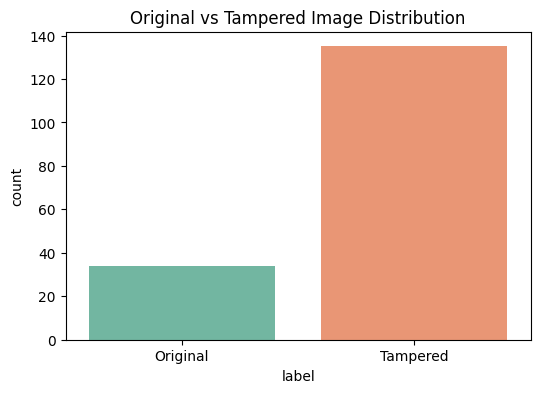

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df_tamper, palette="Set2")
plt.xticks([0,1], ["Original", "Tampered"])
plt.title("Original vs Tampered Image Distribution")
plt.show()


In [ ]:
# ================================
# Objective 2: Tampered Detection
# ================================

import os, cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------
# 1. Dataset Paths
# -------------------------------
DATASET_PATH = "/content/drive/MyDrive/dataset/Tampered images"

records = []
for label, folder in [(0, "Original"), (1, "Tampered")]:
    folder_path = os.path.join(DATASET_PATH, folder)
    if not os.path.exists(folder_path):
        print(f"⚠️ Folder not found: {folder_path}")
        continue
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
                records.append({
                    "filepath": os.path.join(root, f),
                    "label": label
                })

df_tamper = pd.DataFrame(records)
print("✅ Dataset loaded:", len(df_tamper), "images")
print("Original:", (df_tamper['label']==0).sum(), " Tampered:", (df_tamper['label']==1).sum())

# -------------------------------
# 2. Train-Test Split
# -------------------------------
train_df, test_df = train_test_split(
    df_tamper, test_size=0.2, random_state=42, stratify=df_tamper['label']
)

# -------------------------------
# 3. Preprocessing
# -------------------------------
IMG_SIZE = 128

def preprocess_image(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # grayscale
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return np.expand_dims(img, axis=-1)   # (128,128,1)

X_train = np.array([preprocess_image(f) for f in train_df['filepath']])
y_train = np.array(train_df['label'].tolist())

X_test  = np.array([preprocess_image(f) for f in test_df['filepath']])
y_test  = np.array(test_df['label'].tolist())

print("Train:", X_train.shape, y_train.shape, " Test:", X_test.shape, y_test.shape)

# -------------------------------
# 4. CNN Model
# -------------------------------
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # binary output
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# -------------------------------
# 5. Training
# -------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# -------------------------------
# 6. Evaluation + Save
# -------------------------------
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

SAVE_PATH = "/content/drive/MyDrive/Objective2/tampered_cnn.keras"
model.save(SAVE_PATH)
print("💾 Model saved to:", SAVE_PATH)


✅ Dataset loaded: 169 images
Original: 34  Tampered: 135
Train: (135, 128, 128, 1) (135,)  Test: (34, 128, 128, 1) (34,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,993 (394.50 KB)

 Trainable params: 100,993 (394.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 750ms/step - accuracy: 0.7153 - loss: 0.6425 - val_accuracy: 0.7941 - val_loss: 0.5574
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 977ms/step - accuracy: 0.7949 - loss: 0.5566 - val_accuracy: 0.7941 - val_loss: 0.5839
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.7914 - loss: 0.5527 - val_accuracy: 0.7941 - val_loss: 0.5410
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - accuracy: 0.7832 - loss: 0.5251 - val_accuracy: 0.7941 - val_loss: 0.5248
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8248 - loss: 0.4624 - val_accuracy: 0.7941 - val_loss: 0.5040
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 709ms/step - accuracy: 0.8148 - loss: 0.4652 - val_accuracy: 0.7941 - val_loss: 0.4875
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step - accuracy: 0.8062 - loss: 0.4791 - val_accuracy: 0.7941 - val_loss: 0.4853
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7636 - loss: 0.5794 - val_accuracy: 0.7941 - val_loss: 0.475

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Objective2/tampered_cnn.keras'

In [ ]:
import os

SAVE_DIR = "/content/drive/MyDrive/Objective2"
os.makedirs(SAVE_DIR, exist_ok=True)   # 🔹 create folder if not exists

SAVE_PATH = os.path.join(SAVE_DIR, "tampered_cnn.keras")
model.save(SAVE_PATH)

print("💾 Model saved to:", SAVE_PATH)


💾 Model saved to: /content/drive/MyDrive/Objective2/tampered_cnn.keras


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
📊 Classification Report:

              precision    recall  f1-score   support

    Original       0.21      1.00      0.34         7
    Tampered       0.00      0.00      0.00        27

    accuracy                           0.21        34
   macro avg       0.10      0.50      0.17        34
weighted avg       0.04      0.21      0.07        34



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


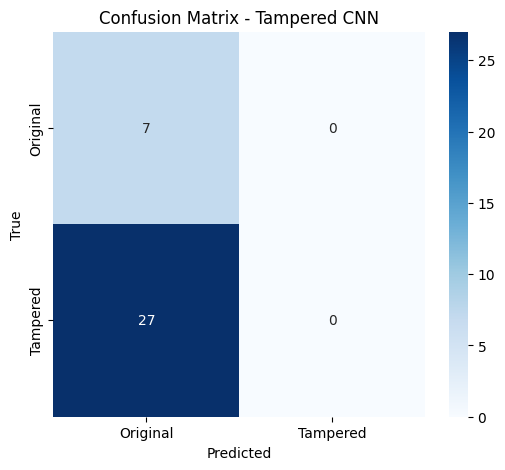

✅ Final Test Accuracy: 20.59%


In [ ]:
# 🔹 Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Agar y_test one-hot nahi hai toh direct use karo
y_true = y_test

# 🔹 Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Original", "Tampered"]))

# 🔹 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Original", "Tampered"],
            yticklabels=["Original", "Tampered"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Tampered CNN")
plt.show()

# 🔹 Final Accuracy
acc = np.mean(y_true == y_pred) * 100
print(f"✅ Final Test Accuracy: {acc:.2f}%")


In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weights
)


Class Weights: {0: np.float64(2.5), 1: np.float64(0.625)}
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 717ms/step - accuracy: 0.8135 - loss: 0.7213 - val_accuracy: 0.7941 - val_loss: 0.5115
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8005 - loss: 0.6581 - val_accuracy: 0.7941 - val_loss: 0.5588
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 672ms/step - accuracy: 0.7997 - loss: 0.6283 - val_accuracy: 0.7941 - val_loss: 0.5691
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.6687 - loss: 0.7020 - val_accuracy: 0.6471 - val_loss: 0.5661
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 669ms/step - accuracy: 0.6642 - loss: 0.6040 - val_accuracy: 0.6176 - val_loss: 0.5628
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 713ms/step - accuracy: 0.5572 - loss: 0.6325 - val_accuracy: 0.5882 - val_loss: 0.5565
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step - accuracy: 0.5805 - loss: 0.6553 - val_accuracy: 0.6176 - val_loss: 0.5587
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step - accuracy: 0

In [ ]:
pip install pdf2image


In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.10 [186 kB]
Fetched 186 kB in 1s (308 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126441 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.10_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.10) ...
Setting up poppler-utils (22.02.0-2ubuntu0.10) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
from pdf2image import convert_from_path
import os

# Example ek hi PDF test ke liye
pdf_path = "/content/drive/MyDrive/dataset/Originals/official/25.pdf"
output_folder = "/content/drive/MyDrive/dataset/ExtraOriginalTest"

os.makedirs(output_folder, exist_ok=True)

# Convert PDF → Images
pages = convert_from_path(pdf_path, dpi=200)

for i, page in enumerate(pages):
    out_file = os.path.join(output_folder, f"25_page_{i+1}.png")
    page.save(out_file, "PNG")
    print("✅ Saved:", out_file)


✅ Saved: /content/drive/MyDrive/dataset/ExtraOriginalTest/25_page_1.png


In [ ]:
import os
import shutil
from pdf2image import convert_from_path

# Input folders
official_dir = "/content/drive/MyDrive/dataset/Originals/official"
wiki_dir = "/content/drive/MyDrive/dataset/Originals/wikipedia"

# Output folder
extra_original_dir = "/content/drive/MyDrive/dataset/ExtraOriginal"
os.makedirs(extra_original_dir, exist_ok=True)

# Helper function to convert PDF → Images
def convert_pdf_to_images(pdf_path, out_dir, prefix):
    try:
        pages = convert_from_path(pdf_path, dpi=200)  # dpi=200 for good quality
        for i, page in enumerate(pages):
            out_file = os.path.join(out_dir, f"{prefix}_page_{i+1}.png")
            page.save(out_file, "PNG")
        print(f"✅ Converted: {pdf_path}")
    except Exception as e:
        print(f"❌ Error in {pdf_path}: {e}")

# Process Official PDFs
for file in os.listdir(official_dir):
    if file.lower().endswith(".pdf"):
        pdf_path = os.path.join(official_dir, file)
        prefix = os.path.splitext(file)[0]
        convert_pdf_to_images(pdf_path, extra_original_dir, f"official_{prefix}")

# Process Wikipedia PDFs
for file in os.listdir(wiki_dir):
    if file.lower().endswith(".pdf"):
        pdf_path = os.path.join(wiki_dir, file)
        prefix = os.path.splitext(file)[0]
        convert_pdf_to_images(pdf_path, extra_original_dir, f"wiki_{prefix}")

print("\n🎯 All PDFs processed! Check ExtraOriginal folder.")


✅ Converted: /content/drive/MyDrive/dataset/Originals/official/9.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/7.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/11.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/13.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/5.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/6.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/16.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/8.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/15.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/18.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/19.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/20.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/21.pdf
✅ Converted: /content/drive/MyDrive/dataset/Originals/official/22.pdf
✅ Converted: /content/dri

In [ ]:
import os
import cv2
import shutil

# 📂 Input paths
original_dir = "/content/drive/MyDrive/dataset/Tampered images/Original"
tampered_dir = "/content/drive/MyDrive/dataset/Tampered images/Tampered"

# 📂 Output paths
extra_original_dir = "/content/drive/MyDrive/dataset/ExtraOriginal"
extra_tampered_dir = "/content/drive/MyDrive/dataset/ExtraTampered"

# Create output folders
os.makedirs(extra_original_dir, exist_ok=True)
os.makedirs(extra_tampered_dir, exist_ok=True)

# 🔹 Function to convert TIF → PNG
def convert_to_png(src_path, dst_folder):
    for root, _, files in os.walk(src_path):
        for file in files:
            if file.lower().endswith(".tif"):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

                if img is None:
                    print(f"⚠️ Could not read {file}, skipping...")
                    continue

                # Save as PNG
                new_name = os.path.splitext(file)[0] + ".png"
                out_path = os.path.join(dst_folder, new_name)
                cv2.imwrite(out_path, img)
                print(f"✅ Converted: {file} → {new_name}")

# 1️⃣ Convert Originals → ExtraOriginal
print("🔹 Converting Originals...")
convert_to_png(original_dir, extra_original_dir)

# 2️⃣ Convert Tampered (with subfolders) → ExtraTampered
print("🔹 Converting Tampered...")
convert_to_png(tampered_dir, extra_tampered_dir)

print("🎉 All TIF files converted to PNG and saved in ExtraOriginal/ and ExtraTampered/")


🔹 Converting Originals...
✅ Converted: s9_51.tif → s9_51.png
✅ Converted: s9_52.tif → s9_52.png
✅ Converted: s9_56.tif → s9_56.png
✅ Converted: s9_58.tif → s9_58.png
✅ Converted: s9_59.tif → s9_59.png
✅ Converted: s9_60.tif → s9_60.png
✅ Converted: s9_61.tif → s9_61.png
✅ Converted: s9_62.tif → s9_62.png
✅ Converted: s9_63.tif → s9_63.png
✅ Converted: s9_67.tif → s9_67.png
✅ Converted: s9_68.tif → s9_68.png
✅ Converted: s11_4.tif → s11_4.png
✅ Converted: s11_19.tif → s11_19.png
✅ Converted: s11_27.tif → s11_27.png
✅ Converted: s11_29.tif → s11_29.png
✅ Converted: s11_30.tif → s11_30.png
✅ Converted: s11_34.tif → s11_34.png
✅ Converted: s11_35.tif → s11_35.png
✅ Converted: s11_36.tif → s11_36.png
✅ Converted: s11_38.tif → s11_38.png
✅ Converted: s11_41.tif → s11_41.png
✅ Converted: s11_49.tif → s11_49.png
✅ Converted: s1_70.tif → s1_70.png
✅ Converted: s1_71.tif → s1_71.png
✅ Converted: s1_72.tif → s1_72.png
✅ Converted: s1_73.tif → s1_73.png
✅ Converted: s1_74.tif → s1_74.png
✅ Convert

In [ ]:
import numpy as np

data = np.array(data)
labels = np.array(labels)

print("✅ Final dataset shape:", data.shape)
print("✅ Labels shape:", labels.shape)
print("🔹 Class 0 (Original):", (labels==0).sum())
print("🔹 Class 1 (Tampered):", (labels==1).sum())


✅ Final dataset shape: (5, 16384)
✅ Labels shape: (5,)
🔹 Class 0 (Original): 5
🔹 Class 1 (Tampered): 0


In [ ]:
import glob, cv2

data, labels = [], []

# Load Original
for f in glob.glob("/content/drive/MyDrive/dataset/ExtraOriginal/*.png"):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (128,128))
    data.append(img.flatten())
    labels.append(0)

# Load Tampered
for f in glob.glob("/content/drive/MyDrive/dataset/ExtraTampered/*.png"):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (128,128))
    data.append(img.flatten())
    labels.append(1)

print("✅ Total:", len(data))
print("🔹 Original:", labels.count(0))
print("🔹 Tampered:", labels.count(1))


✅ Total: 443
🔹 Original: 341
🔹 Tampered: 102


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(data)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (354, 16384) Test: (89, 16384)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.7865168539325843

📊 Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86        69
           1       0.52      0.55      0.54        20

    accuracy                           0.79        89
   macro avg       0.70      0.70      0.70        89
weighted avg       0.79      0.79      0.79        89



✅ Final dataset shape: (443, 16384)
✅ Labels shape: (443,)
🔹 Class 0 (Original): 341
🔹 Class 1 (Tampered): 102
Class Weights -> Original: 272  Tampered: 82
scale_pos_weight: 3.317073170731707


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:37:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Accuracy: 0.797752808988764

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        69
           1       0.55      0.60      0.57        20

    accuracy                           0.80        89
   macro avg       0.71      0.73      0.72        89
weighted avg       0.81      0.80      0.80        89


🔹 Confusion Matrix:
 [[59 10]
 [ 8 12]]


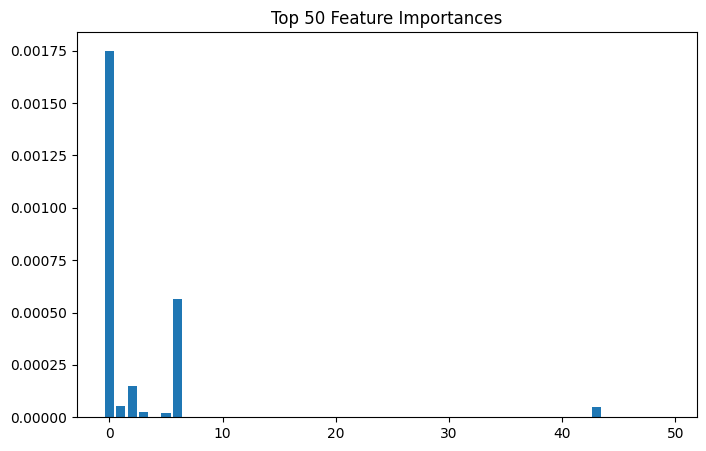

💾 Model saved successfully at /content/drive/MyDrive/Objective2/xgb_model.pkl


In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# =========================
# 1️⃣ Load Dataset
# =========================
data = []
labels = []

# Original images = 0
for f in glob.glob("/content/drive/MyDrive/dataset/ExtraOriginal/*.png"):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    data.append(img.flatten())
    labels.append(0)

# Tampered images = 1
for f in glob.glob("/content/drive/MyDrive/dataset/ExtraTampered/*.png"):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    data.append(img.flatten())
    labels.append(1)

X = np.array(data)
y = np.array(labels)

print("✅ Final dataset shape:", X.shape)
print("✅ Labels shape:", y.shape)
print("🔹 Class 0 (Original):", np.sum(y == 0))
print("🔹 Class 1 (Tampered):", np.sum(y == 1))

# =========================
# 2️⃣ Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 3️⃣ Handle Class Imbalance
# =========================
n_original = np.sum(y_train == 0)
n_tampered = np.sum(y_train == 1)

scale_pos_weight = n_original / n_tampered
print("Class Weights -> Original:", n_original, " Tampered:", n_tampered)
print("scale_pos_weight:", scale_pos_weight)

# =========================
# 4️⃣ Train XGBoost Model
# =========================
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # 👈 imbalance fix
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

# =========================
# 5️⃣ Evaluation
# =========================
y_pred = model.predict(X_test)

print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# =========================
# 6️⃣ Feature Importance Plot
# =========================
plt.figure(figsize=(8,5))
plt.bar(range(len(model.feature_importances_[:50])), model.feature_importances_[:50])
plt.title("Top 50 Feature Importances")
plt.show()

# Save trained XGBoost model
import joblib
joblib.dump(model, "/content/drive/MyDrive/Objective2/xgb_model.pkl")
print("💾 Model saved successfully at /content/drive/MyDrive/Objective2/xgb_model.pkl")



In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from skimage.feature import local_binary_pattern
from scipy.fft import fft2
import matplotlib.pyplot as plt

# Load images from folders
def load_images_from_folder(folder, label):
    data, labels = [], []
    for filename in os.listdir(folder):
        if filename.lower().endswith((".png", ".jpg", ".tif", ".jpeg")):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                data.append(extract_features(img))
                labels.append(label)
    return data, labels

# Feature Extraction: Flatten + LBP + FFT + Residual
def extract_features(img):
    img = img.astype(np.uint8)
    # 1. Flattened pixels
    flat = img.flatten()

    # 2. LBP (local texture)
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59), density=True)

    # 3. FFT magnitude
    fft_mag = np.abs(fft2(img))
    fft_mean = np.mean(fft_mag)
    fft_std = np.std(fft_mag)

    # 4. Residuals (edges)
    edge = cv2.Laplacian(img, cv2.CV_64F)
    edge_mean = np.mean(edge)
    edge_std = np.std(edge)

    # Combine all
    return np.hstack([flat, lbp_hist, fft_mean, fft_std, edge_mean, edge_std])

# Paths
original_path = "/content/drive/MyDrive/dataset/ExtraOriginal"
tampered_path = "/content/drive/MyDrive/dataset/ExtraTampered"

# Load data
X1, y1 = load_images_from_folder(original_path, 0)
X2, y2 = load_images_from_folder(tampered_path, 1)

X = np.array(X1 + X2)
y = np.array(y1 + y2)

print("✅ Final Feature Matrix:", X.shape)
print("✅ Labels:", y.shape)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance
from collections import Counter
class_weights = Counter(y_train)
scale_pos_weight = class_weights[0] / class_weights[1]
print("scale_pos_weight:", scale_pos_weight)

# Train XGBoost
model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', use_label_encoder=False)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Final Feature Matrix: (468, 16447)
✅ Labels: (468,)
scale_pos_weight: 3.5609756097560976


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86        74
           1       0.48      0.50      0.49        20

    accuracy                           0.78        94
   macro avg       0.67      0.68      0.67        94
weighted avg       0.78      0.78      0.78        94

🔹 Confusion Matrix:
 [[63 11]
 [10 10]]


In [ ]:
import joblib
joblib.dump(model, "tampered_xgb_model.pkl")



['tampered_xgb_model.pkl']

In [ ]:
print(np.unique(y))

[0 1]


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# 1️⃣ Load and preprocess images

def load_images_from_folder(folder, label, img_size=(128,128)):
    data, labels = [], []
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0
            data.append(img)
            labels.append(label)
    return data, labels

# Paths

orig_dir = "/content/drive/MyDrive/dataset/ExtraOriginal"
tamper_dir = "/content/drive/MyDrive/dataset/ExtraTampered"

# Load data

orig_imgs, orig_labels = load_images_from_folder(orig_dir, 0)
tamper_imgs, tamper_labels = load_images_from_folder(tamper_dir, 1)

X = np.array(orig_imgs + tamper_imgs).reshape(-1, 128, 128, 1)
y = np.array(orig_labels + tamper_labels)

print("✅ Total samples:", X.shape[0])
print("🔹 Original:", (y == 0).sum())
print("🔹 Tampered:", (y == 1).sum())

# One-hot encode

y_cat = to_categorical(y, num_classes=2)

# 2️⃣ Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

# 3️⃣ Compute class weights (for imbalance)

y_train_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train_integers), y=y_train_integers
)
class_weight_dict = dict(enumerate(class_weights))
print("⚖️ Class Weights:", class_weight_dict)

# 4️⃣ Define CNN model

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 5️⃣ Train

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

# 6️⃣ Evaluate

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final CNN Test Accuracy: {acc:.4f}")

# 7️⃣ Save model

model.save("/content/drive/MyDrive/Objective2/tampered_cnn.keras")
print("💾 Saved model to: /content/drive/MyDrive/Objective2/tampered_cnn.keras")

✅ Total samples: 468
🔹 Original: 366
🔹 Tampered: 102
⚖️ Class Weights: {0: np.float64(0.6404109589041096), 1: np.float64(2.2804878048780486)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,058 (394.76 KB)

 Trainable params: 101,058 (394.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4437 - loss: 0.7386 - val_accuracy: 0.7872 - val_loss: 0.6074
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7407 - loss: 0.7029 - val_accuracy: 0.7872 - val_loss: 0.6030
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7146 - loss: 0.6758 - val_accuracy: 0.7979 - val_loss: 0.4972
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7871 - loss: 0.5383 - val_accuracy: 0.6064 - val_loss: 0.6119
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6314 - loss: 0.5187 - val_accuracy: 0.7660 - val_loss: 0.3797
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 979ms/step - accuracy: 0.7519 - loss: 0.4018 - val_accuracy: 0.7660 - val_loss: 0.4319
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7427 - loss: 0.4330 - val_accuracy: 0.7234 - val_loss: 0.5002
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7479 - loss: 0.4240 - val_accuracy: 0.6809 - val_lo

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
Confusion Matrix:
[[55 19]
 [ 0 20]]


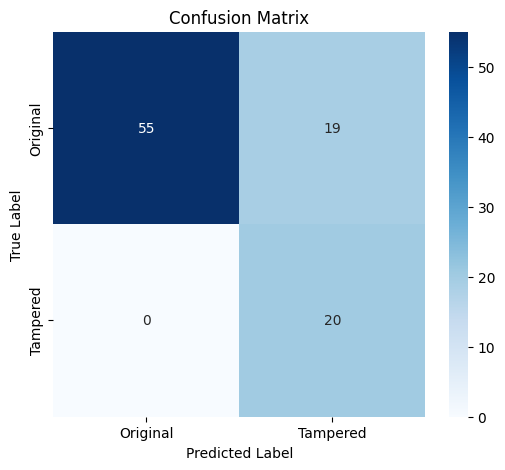


Classification Report:
              precision    recall  f1-score   support

    Original       1.00      0.74      0.85        74
    Tampered       0.51      1.00      0.68        20

    accuracy                           0.80        94
   macro avg       0.76      0.87      0.77        94
weighted avg       0.90      0.80      0.82        94



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Model load karo
model = tf.keras.models.load_model("/content/drive/MyDrive/Objective2/tampered_cnn.keras")

# Test data aur labels yahan load ya define karo
# For example, agar X_test, y_test already defined hain:
# Agar y_test one-hot encoded hai, toh integer labels me convert karna padega
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix calculate karo
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Confusion matrix plot karo
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Original", "Tampered"],
            yticklabels=["Original", "Tampered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report print karo
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Original", "Tampered"]))


Loading data...
Data shape: (468, 128, 128, 1), Labels shape: (468,)
Class weights: {0: np.float64(0.639344262295082), 1: np.float64(2.2941176470588234)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5987 - loss: 1.0066 - val_accuracy: 0.7872 - val_loss: 0.6217
Epoch 2/30
 1/11 ━━━━━━━━━━━━━━━━━━━━ 8s 897ms/step - accuracy: 0.7500 - loss: 0.6854

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7500 - loss: 0.6854 - val_accuracy: 0.7872 - val_loss: 0.5913
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6666 - loss: 0.6887 - val_accuracy: 0.7979 - val_loss: 0.5115
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6364 - loss: 0.7235 - val_accuracy: 0.7872 - val_loss: 0.4253
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7530 - loss: 0.6572 - val_accuracy: 0.7979 - val_loss: 0.3688
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.6875 - loss: 0.6856 - val_accuracy: 0.7979 - val_loss: 0.4170
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7450 - loss: 0.5813 - val_accuracy: 0.7766 - val_loss: 0.3726
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.3438 - loss: 0.7714 - val_accuracy: 0.7766 - val_loss: 0.3742
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5161 - loss: 0.6454 - val_accuracy: 0.7979 - val_loss: 0.4

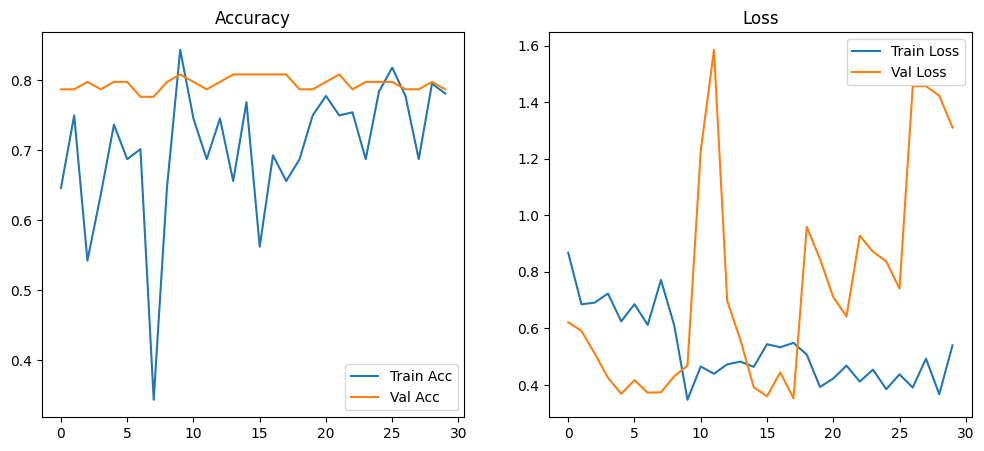

✅ Final CNN Test Accuracy: 0.7872
💾 Model saved to Google Drive.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Paths (update apne dataset ke hisab se)
DATA_DIR_ORIGINAL = "/content/drive/MyDrive/dataset/ExtraOriginal"
DATA_DIR_TAMPERED = "/content/drive/MyDrive/dataset/ExtraTampered"

# Load images and labels
def load_images_and_labels(original_dir, tampered_dir, img_size=(128,128)):
    data = []
    labels = []
    import cv2
    for f in os.listdir(original_dir):
        img_path = os.path.join(original_dir, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(0)  # Original label
    for f in os.listdir(tampered_dir):
        img_path = os.path.join(tampered_dir, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(1)  # Tampered label
    data = np.array(data).astype("float32") / 255.0
    data = np.expand_dims(data, -1)  # (N, 128, 128, 1)
    labels = np.array(labels)
    return data, labels

print("Loading data...")
X, y = load_images_and_labels(DATA_DIR_ORIGINAL, DATA_DIR_TAMPERED)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Encode labels & one-hot
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_enc)

# Compute class weights
class_weights_raw = compute_class_weight("balanced", classes=np.unique(y_enc), y=y_enc)
class_weights = {i : w for i, w in enumerate(class_weights_raw)}
print("Class weights:", class_weights)

# Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Build CNN Model
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn()
model.summary()

# Train model with augmentation and class weights
batch_size = 32
epochs = 30

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    verbose=1
)

# Plot accuracy and loss curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

# Evaluate on test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Final CNN Test Accuracy: {test_acc:.4f}")

# Save model
model.save("/content/drive/MyDrive/Objective2/tampered_cnn_augmented.keras")
print("💾 Model saved to Google Drive.")



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"✅ Final Test Accuracy: {acc:.4f}")

target_names = ['Original', 'Tampered']  # Apne labels ke hisaab se adjust karo
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
print("\n🔹 Confusion Matrix:")
print(cm)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step
✅ Final Test Accuracy: 0.7872

📊 Classification Report:
              precision    recall  f1-score   support

    Original       0.79      1.00      0.88        74
    Tampered       0.00      0.00      0.00        20

    accuracy                           0.79        94
   macro avg       0.39      0.50      0.44        94
weighted avg       0.62      0.79      0.69        94


🔹 Confusion Matrix:
[[74  0]
 [20  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Paths to your data folders (change accordingly)
original_dir = "/content/drive/MyDrive/dataset/ExtraOriginal"
tampered_dir = "/content/drive/MyDrive/dataset/ExtraTampered"

IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30

# Load image paths and labels
def load_images_and_labels():
    import cv2, glob

    data, labels = [], []
    for label, folder in [(0, original_dir), (1, tampered_dir)]:
        files = glob.glob(os.path.join(folder, "*.png"))
        for f in files:
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype("float32") / 255.0
            img = np.stack((img,)*3, axis=-1)  # Convert grayscale to 3 channels for EfficientNet
            data.append(img)
            labels.append(label)
    return np.array(data), np.array(labels)

print("Loading data...")
X, y = load_images_and_labels()
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# Build model using EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # Freeze base initially

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train frozen model first
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

# Unfreeze base model for fine-tuning
base_model.trainable = True

# Lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    epochs=EPOCHS-10,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

# Save model
model.save("/content/drive/MyDrive/Objective2/tampered_cnn_transfer_learning.keras")
print("Model saved!")

# You can later evaluate or plot accuracy/loss curves similarly.


Loading data...
Data shape: (443, 128, 128, 3), Labels shape: (443,)
Class weights: {0: np.float64(0.6507352941176471), 1: np.float64(2.158536585365854)}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4523 - loss: 0.7371 - val_accuracy: 0.7753 - val_loss: 0.6783
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4462 - loss: 0.7513 - val_accuracy: 0.7753 - val_loss: 0.5804
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4493 - loss: 0.7946 - val_accuracy: 0.2247 - val_loss: 0.7301
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5059 - loss: 0.6854 - val_accuracy: 0.2247 - val_loss: 0.7456
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4868 - loss: 0.6930 - val_accuracy: 0.7865 - val_loss: 0.6905
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5039 - loss: 0.7426 - val_accuracy: 0.7753 - val_loss: 0.6559
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6508 - loss: 0.7189 - val_accuracy: 0.7753 - val_loss: 0.6358
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4846 - loss: 0.7328 - val_accuracy: 0.2247 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Confusion Matrix:
[[74  0]
 [20  0]]


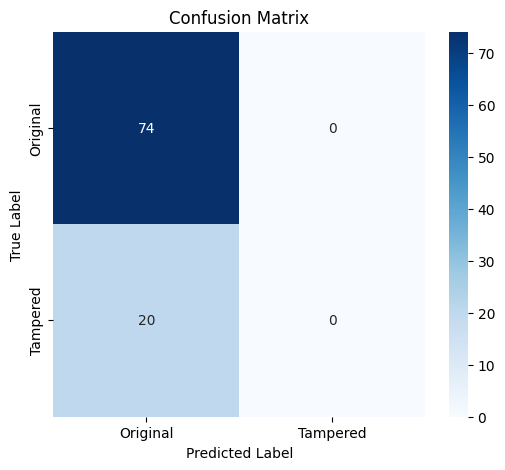


Classification Report:
              precision    recall  f1-score   support

    Original       0.79      1.00      0.88        74
    Tampered       0.00      0.00      0.00        20

    accuracy                           0.79        94
   macro avg       0.39      0.50      0.44        94
weighted avg       0.62      0.79      0.69        94



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/Objective2/tampered_cnn_transfer_learning.keras")

# Assume X_test and y_test are your test data and labels (one-hot encoded or integer labels)
# Agar y_test one-hot encoded hai toh usse integer labels me convert karo:
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Predictions (probabilities)
y_pred_probs = model.predict(X_test)
# Class predictions (integer labels)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Original", "Tampered"],
            yticklabels=["Original", "Tampered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Original", "Tampered"]))


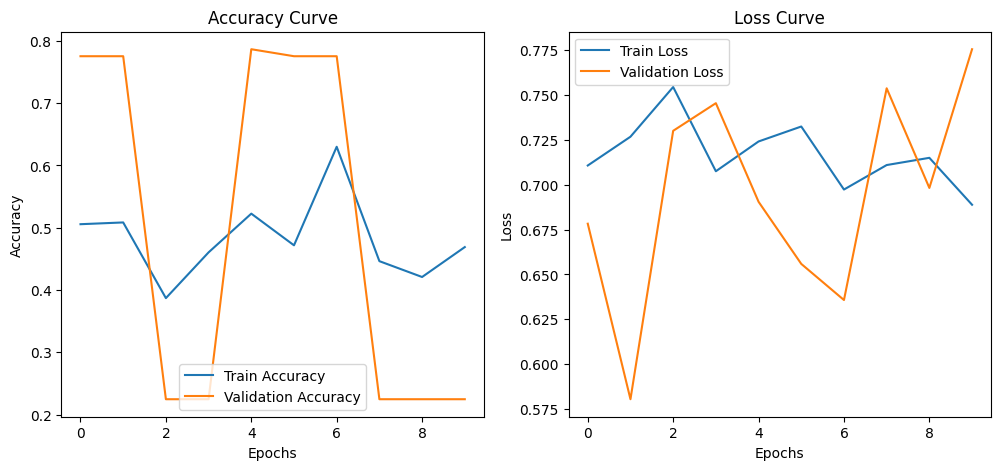

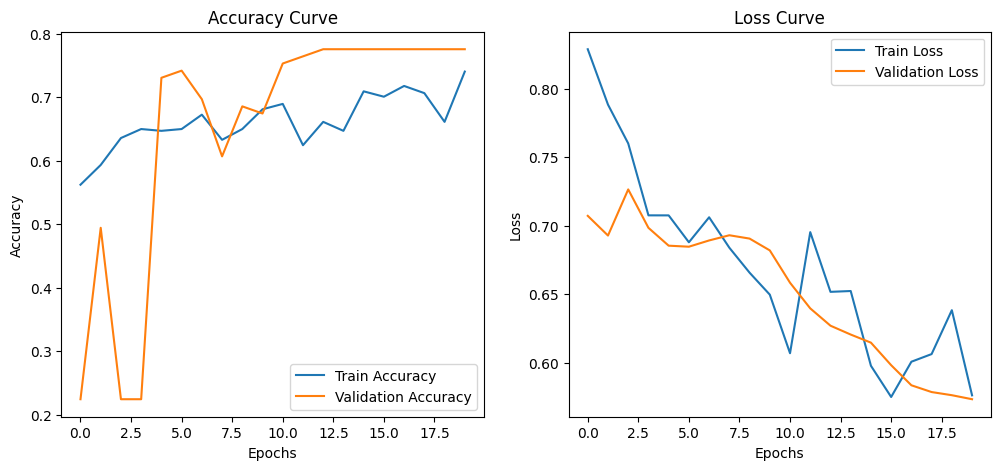

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Accuracy plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Usage:
# Agar tumne pehle freeze stage me train kiya tha toh:
plot_training(history)

# Fir fine-tuning stage ke baad:
plot_training(history_finetune)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 978ms/step
✅ Ensemble Majority Voting Accuracy: 0.8089887640449438

📊 Report (Voting):
               precision    recall  f1-score   support

           0       0.88      0.87      0.88        69
           1       0.57      0.60      0.59        20

    accuracy                           0.81        89
   macro avg       0.73      0.73      0.73        89
weighted avg       0.81      0.81      0.81        89



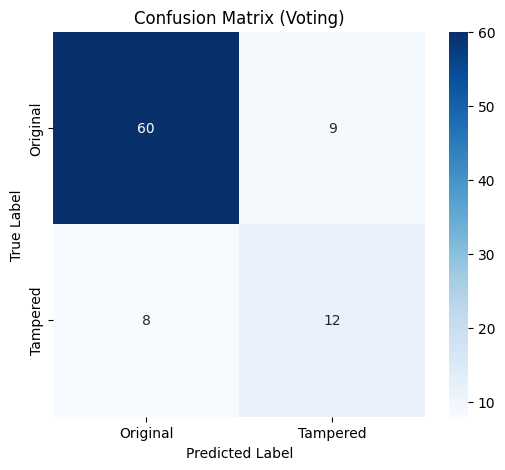


✅ Weighted Ensemble Accuracy: 0.8764044943820225

📊 Report (Weighted):
               precision    recall  f1-score   support

           0       1.00      0.84      0.91        69
           1       0.65      1.00      0.78        20

    accuracy                           0.88        89
   macro avg       0.82      0.92      0.85        89
weighted avg       0.92      0.88      0.88        89



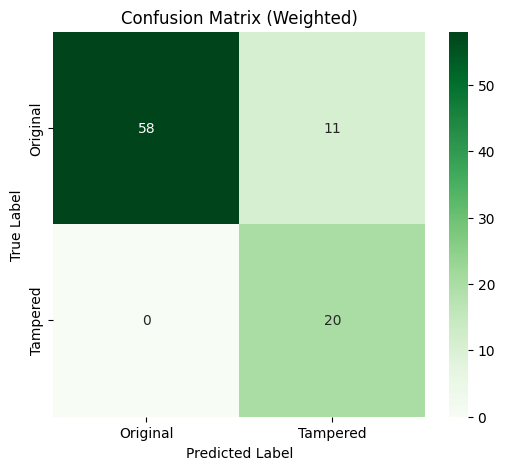

In [ ]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# 1️⃣ Load Saved Models
# ======================
xgb_model = joblib.load("/content/drive/MyDrive/Objective2/xgb_model.pkl")
cnn_model = load_model("/content/drive/MyDrive/Objective2/tampered_cnn.keras")

# ======================
# 2️⃣ Prepare Test Sets
# ======================
# NOTE: y_test and X_test must already be loaded from your dataset step

# y_true (convert one-hot to integer if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# XGB needs flattened features
X_test_xgb = X_test.reshape(len(X_test), -1)        # shape (N,16384)

# CNN needs 128x128x1 images
X_test_cnn = X_test.reshape(len(X_test), 128,128,1) # shape (N,128,128,1)

# ======================
# 3️⃣ Predictions
# ======================
# XGBoost
y_pred_xgb = xgb_model.predict(X_test_xgb)
proba_xgb = xgb_model.predict_proba(X_test_xgb)[:,1]

# CNN
y_pred_cnn_probs = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

if cnn_model.output_shape[-1] == 1:
    proba_cnn = y_pred_cnn_probs[:,0]  # sigmoid output
else:
    proba_cnn = y_pred_cnn_probs[:,1]  # softmax tampered class

# ======================
# 4️⃣ Majority Voting
# ======================
preds = np.vstack([y_pred_xgb, y_pred_cnn]).T
y_pred_voting = mode(preds, axis=1).mode.flatten()

print("✅ Ensemble Majority Voting Accuracy:", accuracy_score(y_true, y_pred_voting))
print("\n📊 Report (Voting):\n", classification_report(y_true, y_pred_voting))

cm_voting = confusion_matrix(y_true, y_pred_voting)
plt.figure(figsize=(6,5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Original", "Tampered"],
            yticklabels=["Original", "Tampered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Voting)")
plt.show()

# ======================
# 5️⃣ Weighted Ensemble
# ======================
final_proba = 0.6*proba_cnn + 0.4*proba_xgb   # tweak weights if needed
y_pred_weighted = (final_proba > 0.5).astype(int)

print("\n✅ Weighted Ensemble Accuracy:", accuracy_score(y_true, y_pred_weighted))
print("\n📊 Report (Weighted):\n", classification_report(y_true, y_pred_weighted))

cm_weighted = confusion_matrix(y_true, y_pred_weighted)
plt.figure(figsize=(6,5))
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Original", "Tampered"],
            yticklabels=["Original", "Tampered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Weighted)")
plt.show()
